In [23]:
import re
import csv
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def strip_integers(line):
  return re.findall(r'[0-9]+', line)

In [25]:
# Trial format for overhead
# # Trial 1 with w=25

# * serial
# Program: m=2000, n=1, w=25, u=1, d=-1, e=1, (null), (null)
# Total Time Handling Packets: 2000.093994
# Total Packets: 14227399

# Trial format for uniform and exponential
# # Trial 1 with n=1 and w=1000

# * serial
# Program: m=2000, n=1, w=1000, u=1, d=-1, e=1, (null), (null)
# Total Time Handling Packets: 2000.105957
# Total Packets: 820287

In [26]:
def get_all_program_types():
  locks = ['mutex', 'clh']
  strategies = ['homequeue', 'awesome']
  combo = list(itertools.product(locks, strategies))
  combo = [' '.join(elm) for elm in combo]
  combo = ['lockfree'] + combo  # one more program: serial
  return combo

In [27]:
def parse_trial_header(header):
  params = re.match(r'\s*Trial ([0-9]+) with (n=([0-9]+))?.*?w=([0-9]+)', 
                      header)
  trial_no = int(params.group(1))
  mean = int(params.group(4))
  threads = 1 if params.group(3) is None else int(params.group(3))
  data = {'Trial': trial_no, 'W': mean, 'n': threads}
  return data

In [28]:
def parse_trial_chunk(chunk):
    prog_type = chunk.split('\n')[0][1:]  # remove leading whitespace
    num_pkt = re.findall(r'Total Packets: ([0-9]+)', chunk)[0]
    data = {'Program': prog_type, 'T': int(num_pkt)}
    return data

In [29]:
def part_to_df(part):
  cols = ['Trial', 'Program', 'n', 'W', 'T']
  df = pd.DataFrame(columns=cols)
  trials = part.split('#')[1:]
  for trial in trials:
    header = trial.split('*')[0]
    chunks = trial.split('*')[1:]
    header_dict = parse_trial_header(header)
    for chunk in chunks:
      chunk_dict = parse_trial_chunk(chunk)
      row = {**header_dict, **chunk_dict}
      df = df.append(row, ignore_index=True)
  return df

In [30]:
def file_to_raw_dfs(fname):
  with open(fname, 'r') as f:
    raw = f.read()
  parts = raw.split('###')[1:]
  ret = []
  for part in parts:
    ret.append(part_to_df(part))
  return ret

In [31]:
# raw_dfs = file_to_raw_dfs('result/master.txt')
# overhead, uniform, exponential = raw_dfs
# overhead.drop(columns=['n']).to_csv('result/overhead.csv', index=False)
# uniform.to_csv('result/uniform.csv', index=False)
# exponential.to_csv('result/exponential.csv', index=False)

Start Data Analysis

In [32]:
overhead = pd.read_csv('result/overhead2.csv')
uniform = pd.read_csv('result/uniform2.csv')
exponential = pd.read_csv('result/exponential.csv')

Overhead

In [33]:
df = overhead.groupby(['Program', 'W']).median()
df = df.drop(columns=['Trial']).reset_index()
lf = df.loc[df['Program'] == 'lockfree']
mutex = df.loc[df['Program'] == 'mutex homequeue']
clh = df.loc[df['Program'] == 'clh homequeue']

In [34]:
speedup = mutex['T'].div(lf['T'].values, axis=0)
mutex.insert(1, 'Speedup', speedup)
speedup = clh['T'].div(lf['T'].values, axis=0)
clh.insert(1, 'Speedup', speedup)
new_df = pd.concat([mutex, clh])

<Figure size 432x288 with 0 Axes>

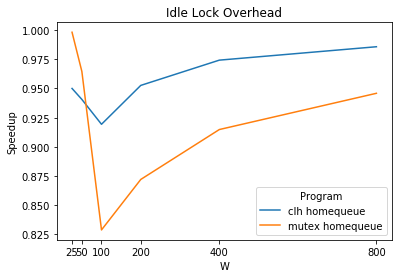

In [35]:
plt.figure()
temp = new_df.drop(columns='T')
temp = temp.pivot(index='W', columns='Program', values='Speedup')
temp.plot(title='Idle Lock Overhead')
plt.xticks([25, 50, 100, 200, 400, 800])
plt.ylabel('Speedup')
plt.show()

<Figure size 432x288 with 0 Axes>

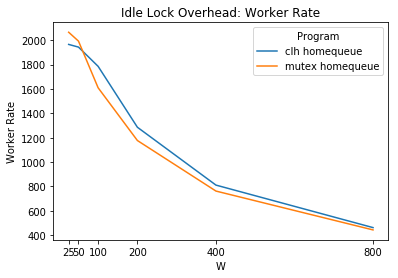

In [36]:
new_df['Worker Rate'] = round(new_df['T'] / 2000)
plt.figure()
temp = new_df.drop(columns=['T', 'Speedup'])
temp = temp.pivot(index='W', columns='Program', values='Worker Rate')
temp.plot(title='Idle Lock Overhead: Worker Rate')
plt.xticks([25, 50, 100, 200, 400, 800])
plt.ylabel('Worker Rate')
plt.show()

In [37]:
df1 = new_df.pivot(index='W', columns='Program', values='Speedup')
df2 = new_df.pivot(index='W', columns='Program', values='Worker Rate')
print(df1.reset_index().to_latex(index=False))
print(df2.reset_index().to_latex(index=False))

\begin{tabular}{rrr}
\toprule
   W &  clh homequeue &  mutex homequeue \\
\midrule
  25 &       0.950015 &         0.998141 \\
  50 &       0.940621 &         0.964571 \\
 100 &       0.919337 &         0.828886 \\
 200 &       0.952626 &         0.872104 \\
 400 &       0.974253 &         0.914832 \\
 800 &       0.985727 &         0.945864 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrr}
\toprule
   W &  clh homequeue &  mutex homequeue \\
\midrule
  25 &         1966.0 &           2066.0 \\
  50 &         1944.0 &           1993.0 \\
 100 &         1786.0 &           1610.0 \\
 200 &         1286.0 &           1177.0 \\
 400 &          811.0 &            762.0 \\
 800 &          462.0 &            443.0 \\
\bottomrule
\end{tabular}



For both Uniform and Exponential

In [38]:
def to_df_given_mean(table, mean):
  chunk = table.loc[table['W'] == mean]
  serial = chunk.loc[chunk['Program'] == 'serial']
  splits = []

  for elm in get_all_program_types():
    split = chunk.loc[chunk['Program'] == elm]
    speedup = split['T'].div(serial['T'].values, axis=0)
    split.insert(1, 'Speedup', speedup)
    splits.append(split)
  return pd.concat(splits)

In [39]:
def plot_given_mean(table, mean, pkt_type):
  plt.figure()
  temp = table.drop(columns=['T', 'W'])
  temp = temp.pivot(index='n', columns='Program', values='Speedup')
  title = 'Speedup with ' + pkt_type.capitalize() + ' with W = ' + str(mean)
  temp.plot(title=title)
  plt.xticks([2, 3, 4, 8, 14, 28])
  plt.xlabel('n + 1')
  plt.ylabel('Speedup')
  plt.show()

Uniform

In [40]:
unif_df = uniform.groupby(['Program', 'W', 'n']).median()
unif_df = unif_df.drop(columns=['Trial']).reset_index()
unif_dfs = []
for mean in [1000, 2000, 4000, 8000]:
  unif_dfs.append(to_df_given_mean(unif_df, mean))

In [41]:
for u_df in unif_dfs:
  u_df = u_df.pivot(index='n', columns='Program', values='Speedup')
  print(u_df.reset_index().to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
  n &  clh awesome &  clh homequeue &  lockfree &  mutex awesome &  mutex homequeue \\
\midrule
  1 &     0.925826 &       0.925262 &  0.936230 &       0.892713 &         0.893472 \\
  2 &     1.849138 &       1.825568 &  1.850476 &       1.775845 &         1.742910 \\
  3 &     2.763411 &       2.719987 &  2.721474 &       2.661429 &         2.601850 \\
  7 &     5.106652 &       6.114621 &  5.805225 &       6.145542 &         5.926584 \\
 13 &     2.758132 &       4.186333 &  4.025248 &       3.624687 &         4.966193 \\
 27 &     1.780912 &       1.570155 &  1.045049 &       2.862886 &         2.506850 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrr}
\toprule
  n &  clh awesome &  clh homequeue &  lockfree &  mutex awesome &  mutex homequeue \\
\midrule
  1 &     0.961614 &       0.961590 &  0.967127 &       0.942283 &         0.942981 \\
  2 &     1.921313 &       1.889776 &  1.899202 &       1.887126 &         1.856701 \\
  3 &     2.888571 

<Figure size 432x288 with 0 Axes>

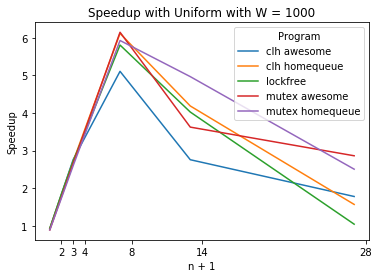

<Figure size 432x288 with 0 Axes>

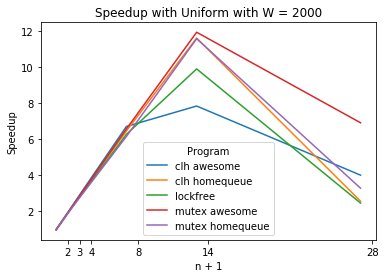

<Figure size 432x288 with 0 Axes>

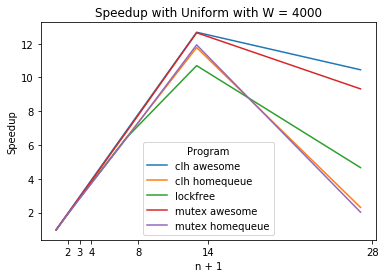

<Figure size 432x288 with 0 Axes>

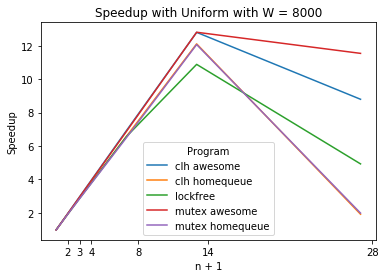

In [42]:
for u_df, mean in zip(unif_dfs, [1000, 2000, 4000, 8000]):
  plot_given_mean(u_df, mean, 'Uniform')

Exponential

In [44]:
exp_df = exponential.groupby(['Program', 'W', 'n']).median()
exp_df = exp_df.drop(columns=['Trial']).reset_index()
exp_dfs = []
for mean in [1000, 2000, 4000, 8000]:
  exp_dfs.append(to_df_given_mean(exp_df, mean))

In [45]:
for e_df in exp_dfs:
  e_df = e_df.pivot(index='n', columns='Program', values='Speedup')
  print(e_df.reset_index().to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
  n &  clh awesome &  clh homequeue &  lockfree &  mutex awesome &  mutex homequeue \\
\midrule
  1 &     0.948085 &       0.947746 &  0.958775 &       0.916876 &         0.918039 \\
  2 &     1.824119 &       1.534714 &  1.547302 &       1.754784 &         1.449354 \\
  3 &     2.731269 &       2.009284 &  2.008326 &       2.621170 &         1.899069 \\
  7 &     4.082885 &       3.701842 &  3.745670 &       4.611840 &         3.659626 \\
 13 &     2.614281 &       3.892269 &  3.733764 &       3.435594 &         4.443702 \\
 27 &     2.031875 &       1.390120 &  1.613430 &       2.714537 &         0.761885 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrr}
\toprule
  n &  clh awesome &  clh homequeue &  lockfree &  mutex awesome &  mutex homequeue \\
\midrule
  1 &     0.973739 &       0.973426 &  0.978738 &       0.955031 &         0.955468 \\
  2 &     1.908980 &       1.561193 &  1.568615 &       1.879012 &         1.515982 \\
  3 &     2.876848 

<Figure size 432x288 with 0 Axes>

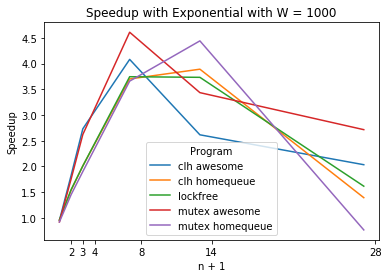

<Figure size 432x288 with 0 Axes>

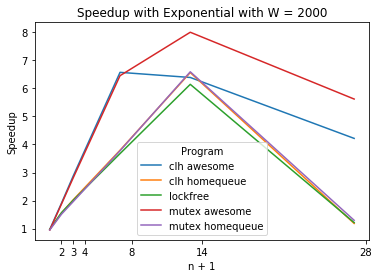

<Figure size 432x288 with 0 Axes>

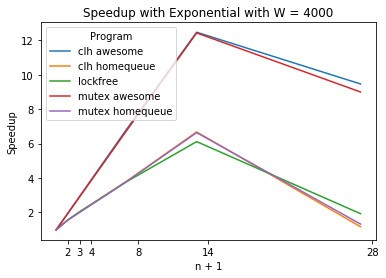

<Figure size 432x288 with 0 Axes>

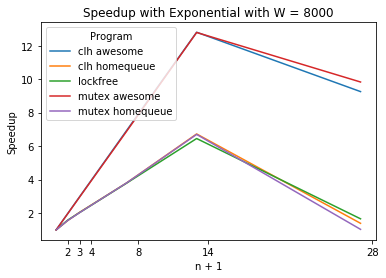

In [46]:
for e_df, mean in zip(exp_dfs, [1000, 2000, 4000, 8000]):
  plot_given_mean(e_df, mean, 'Exponential')

In [57]:
temp = unif_dfs[3].pivot(index='n', columns='Program', values='Speedup')
clh = temp['clh awesome'] / temp['lockfree']
mutex = temp['mutex awesome'] / temp['lockfree']
ratios = pd.DataFrame({'clh uniform': clh, 
                       'mutex uniform': mutex})
temp = exp_dfs[3].pivot(index='n', columns='Program', values='Speedup')
clh = temp['clh awesome'] / temp['lockfree']
mutex = temp['mutex awesome'] / temp['lockfree']
ratios['clh exp'] = clh
ratios['mutex exp'] = mutex

print(ratios.reset_index().to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
  n &  clh uniform &  mutex uniform &   clh exp &  mutex exp \\
\midrule
  1 &     0.998862 &       0.993700 &  0.998809 &   0.993529 \\
  2 &     1.018329 &       1.014167 &  1.252831 &   1.246656 \\
  3 &     1.032976 &       1.027798 &  1.466642 &   1.457196 \\
  7 &     1.054485 &       1.046961 &  1.830702 &   1.818469 \\
 13 &     1.175994 &       1.176550 &  1.984701 &   1.982589 \\
 27 &     1.783439 &       2.339921 &  5.601831 &   5.948907 \\
\bottomrule
\end{tabular}

